<a href="https://colab.research.google.com/github/weikhar/NLP/blob/master/%5BLearn%5D%20Project_National_Day_Rally.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries required for analysis

In [0]:
#import the libraries to be used
import requests
from bs4 import BeautifulSoup
import nltk
import numpy as np
import string
import wordcloud
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import random
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('popular')
nltk.download('vader_lexicon')

# we will use the sentiment intensity analyzer (you can try other stuff too)
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
# define the years 
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

# declare empty lists
speeches = []
colors = []
speech_list = []

text_tokenized = {}
pol_score = {}

# define the number of topics for topic modelling
number_of_topics = 5
no_top_words = 8


# Helper functions to perform the analysis

In [0]:
# sort the dictionary
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux
  
  
# clean the speech
def clean_words(speech):

  # tokenize words
  words = nltk.tokenize.word_tokenize(speech)

  # convert to lowercase
  words_lower = [word.lower() for word in words]

  # remove punctuation from each word
  table = str.maketrans('', '', string.punctuation)
  stripped = [word.translate(table) for word in words_lower]

  # remove non - alphabetic words
  words = [word for word in stripped if word.isalpha()]

  # remove stopwords/common words
  nltk_stopwords = nltk.corpus.stopwords.words('english')

  # display top 10 most common stopwords
  print('Number of stop words: %d' % len(nltk_stopwords))
  print('First ten stop words: %s' % list(nltk_stopwords)[:10])

  words_tokenized = [word for word in words if not word in nltk_stopwords]
  
  word_freq = [words_tokenized.count(p) for p in words_tokenized]
  
  return sortFreqDict(dict(zip(words_tokenized,word_freq)))


# generate wordclouds
def word_cloud_gen(speech):
  plt.figure(1)
  speech_wordcloud = wordcloud.WordCloud().generate(speech)
  
  # display the generated image using matplotlib
  plt.imshow(speech_wordcloud, interpolation='bilinear')

  #remove the weird axis
  plt.axis("off")
  
  #command to show plot
  plt.show()


#visualize the tokenized words per year
def visualize_graph(words_tokenized, year):
  plt.figure(2)
  words = [];
  counts = [];
  for word, freq in words_tokenized[:30]:
    words.append(word)
    counts.append(freq)
  
  colors = cm.rainbow(np.linspace(0, 1, 10))
  rcParams['figure.figsize'] = 20, 10
  plt.title('Top words in the headlines vs their count' + ' ' + str(year))
  plt.xlabel('Count')
  plt.ylabel('Words')
  plt.barh(counts, words, color=colors)
  
# perform sentiment analysis
def sentiment_analysis(text):
  sia = SIA()
  
  #tokenize text into sentences
  sentences_list = nltk.tokenize.sent_tokenize(text)
  
  results = []
  
  for line in sentences_list:
    pol_score = sia.polarity_scores(line)
    pol_score['text'] = line
    results.append(pol_score)
  return results

# visualize the sentiment
def visualize_sentiment_analysis(pol_score, year):
  plt.figure(3)
  
  neg = []
  pos = []
  neu = []
  compound = []
  
  for sent_index in range(len(pol_score[year])):
    pos.append(pol_score[year][sent_index]['pos'])
    neg.append(pol_score[year][sent_index]['neg'])
    neu.append(pol_score[year][sent_index]['neu'])
    compound.append(pol_score[year][sent_index]['compound'])
      

  sentence_index_list = range(len(pol_score[year]))
  plt.plot(sentence_index_list, pos, color = 'green', marker = 'o', linestyle = 'dashed', linewidth = 2, markersize = 12)
  plt.plot(sentence_index_list, neg, color = 'red', marker = 'o', linestyle = 'dashed', linewidth = 2, markersize = 12)
  plt.plot(sentence_index_list, neu, color = 'gray', marker = 'o', linestyle = 'dashed', linewidth = 2, markersize = 12)
  plt.plot(sentence_index_list, compound, color = 'purple', marker = 'o', linestyle = 'dashed', linewidth = 2, markersize = 12)
  plt.title('Top words in the headlines vs their count' + ' ' + str(year))
  plt.xlabel('Sentence Index')
  plt.ylabel('score')   
  plt.legend()
  plt.show()
  
# perform normalization on the sentiment scores and sentence index
def normalization(sentence_index_list, moving_average_compound_scores):    
  pd_frame = pd.DataFrame({"sentence_index": sentence_index_list, "score": moving_average_compound_scores})
  scaled_index = (pd_frame['sentence_index'] - pd_frame['sentence_index'].min()) / (pd_frame['sentence_index'].max() - pd_frame['sentence_index'].min())
  scaled_scores = (pd_frame['score'] - pd_frame['score'].min()) / (pd_frame['score'].max() - pd_frame['score'].min())
  pd_frame['scaled_scores'] = scaled_scores
  pd_frame['scaled_index'] = scaled_index
  pd_frame = pd_frame.drop(['sentence_index', 'score'], 1)
  return pd_frame
  
# plot the overall sentiment score
def display_overall_score(pol_score, years, window):
  plt.figure(4)
  
  yearly_compound_score = []
  moving_average_compound_scores = []
  color_list = []
  frame_list = []
  
  for year in years:
    color = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]
    if color not in color_list:
      color_list.append(color)
  
  count = 0
  for year in years:
    for sent_index in range(len(pol_score[year])):
      if len(yearly_compound_score)<window:
        yearly_compound_score.append(pol_score[year][sent_index]['compound'])
        
      elif len(yearly_compound_score)==window:
        moving_average_compound_score = sum(yearly_compound_score)/window
        moving_average_compound_scores.append(moving_average_compound_score)
        yearly_compound_score = []
      
    moving_average_compound_score = sum(yearly_compound_score)/len(yearly_compound_score)
    moving_average_compound_scores.append(moving_average_compound_score)
    print(len(moving_average_compound_scores))
    sentence_index_list = [window*i for i in list(range(len(moving_average_compound_scores)))]
    pd_frame = normalization(sentence_index_list, moving_average_compound_scores)
    #print(pd_frame)
    # append the data frames into a list first
    frame_list.append(pd_frame)
    
    #if you loop and plot you'll get that weird error
    #plt.plot(pd_frame['scaled_index'], pd_frame['scaled_scores'], color_list[count] , linewidth = 1, label = str(year))
    count+=1        
    moving_average_compound_scores = []
  
  
  for i in range(len(frame_list)):
    plt.plot(frame_list[i]['scaled_index'], frame_list[i]['scaled_scores'], linewidth = 1, label = str(2008 + i))
  plt.xlabel('Sentence Index')
  plt.ylabel('compound score')
  plt.legend(loc = 'upper left')
  plt.show()

# spplit a text into paragraphs
def split_text_into_paras(text):
  sentences_per_para = 10
  sentences_list = nltk.tokenize.sent_tokenize(text)
  para_list = []
  new_para = ''
  sent_count_per_para = 0
  
  for sentence in sentences_list:
    if (sent_count_per_para < sentences_per_para):
      new_para+=sentence
      sent_count_per_para+=1
    elif(sent_count_per_para==sentences_per_para):
      para_list.append(new_para)
      new_para = ''
      sent_count_per_para = 0
  para_list.append(new_para)
  return para_list

# display topics
def display_topics(model, feature_names, no_top_word):
  top_20_topics = []
  for topic_idx, topic in enumerate(model.components_):
    print ("Topic %d:" % (topic_idx))
    print (" ".join([feature_names[i]
      for i in topic.argsort()[:-no_top_words - 1:-1]]))

# topic modeller
def topic_modeller(para_list):
  words = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
  bag_of_words = words.fit_transform(para_list)
  word_names = words.get_feature_names()
  lda = LDA(n_components = number_of_topics).fit(bag_of_words)
  display_topics(lda, word_names, no_top_words)

# Putting it all together

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
work children singapore new people women quite good want life
Topic 1:
think make singaporeans oil people got lot know things money
Topic 2:
people internet think political just public like new important make
Topic 3:
singapore good people got economy let year opportunities prices way
Topic 4:
think year people income singaporeans years help time way middle


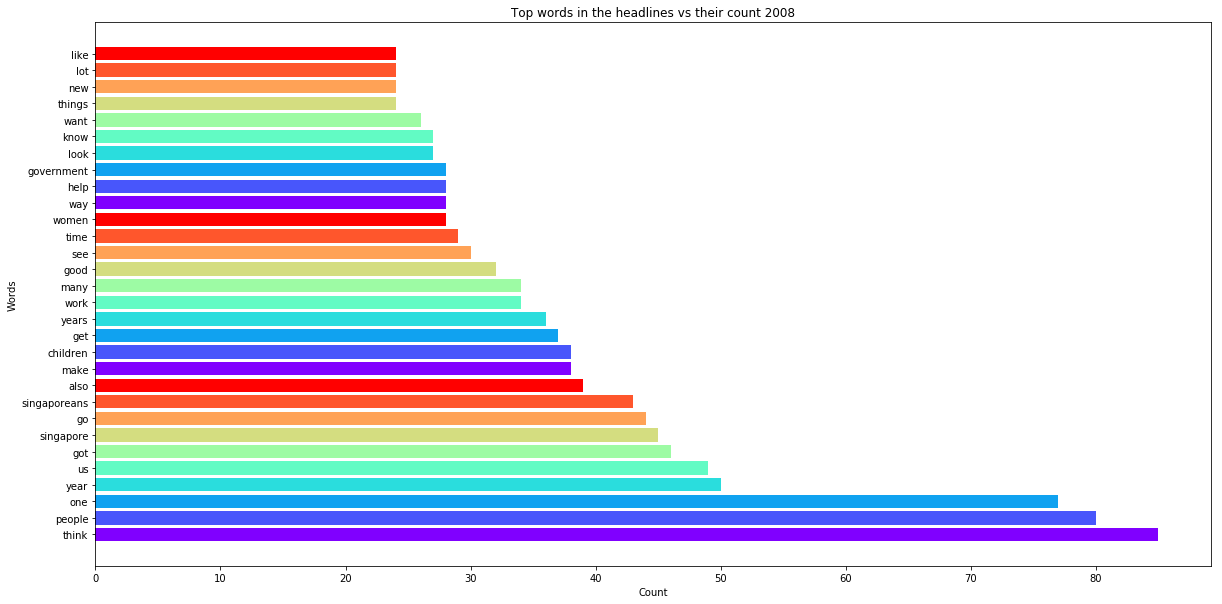

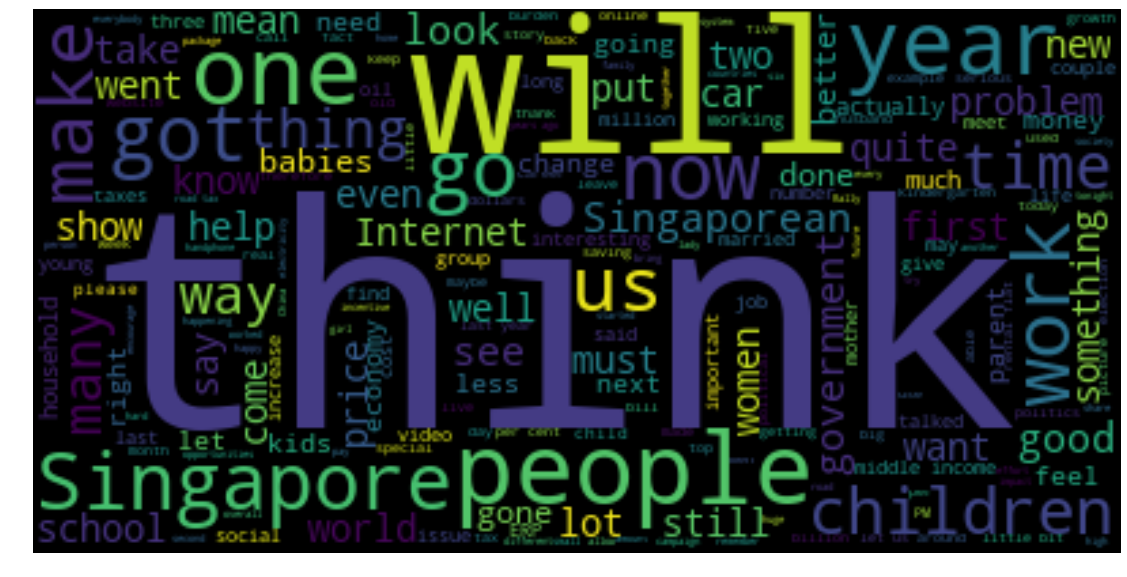

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
singapore religious government time know harmony problem think new group
Topic 1:
need people home patients hospital new care think community good
Topic 2:
singapore good groups muslim just jobs work new different community
Topic 3:
family schools people wanted malay school said singapore chinese wedding
Topic 4:
singapore religious just people good groups let doing way society


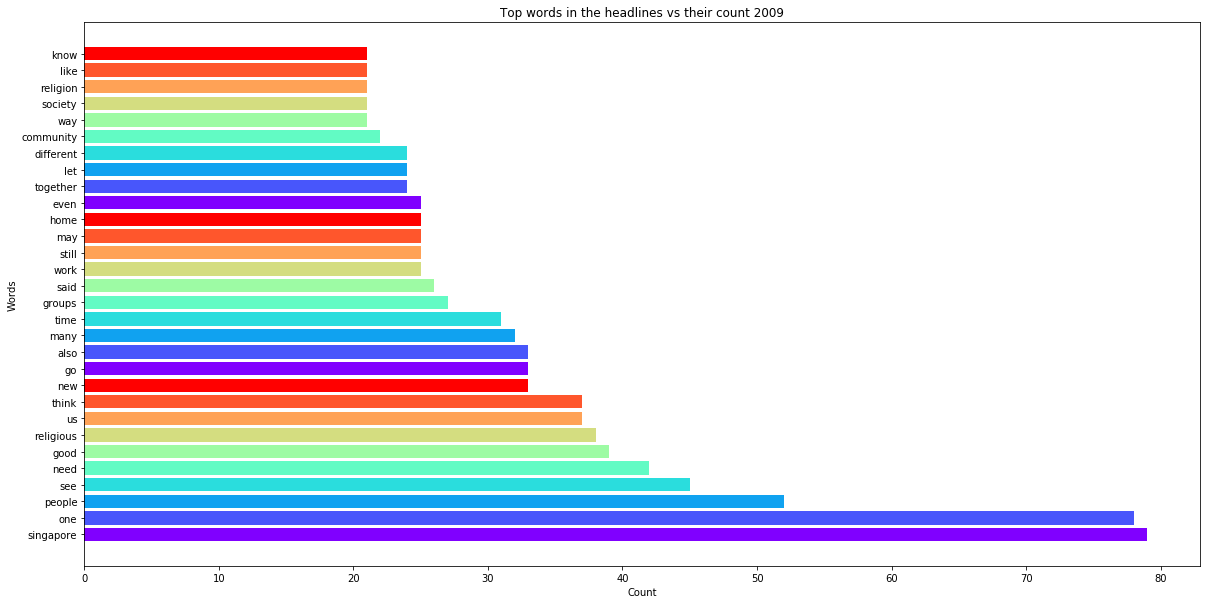

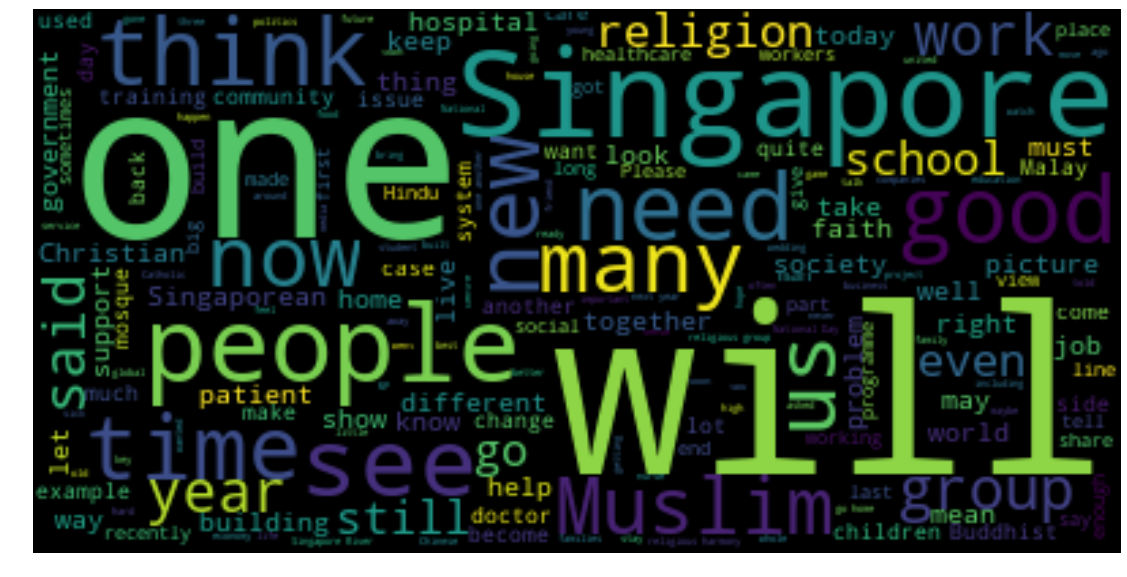

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
singapore goh dr education generation poly people new young like
Topic 1:
singapore singaporeans workers foreign year flats years 000 time think
Topic 2:
line foreign good need think workers students new train singapore
Topic 3:
students singapore new kids think schools young make people singaporeans
Topic 4:
good oil singapore school make doing programme working business right


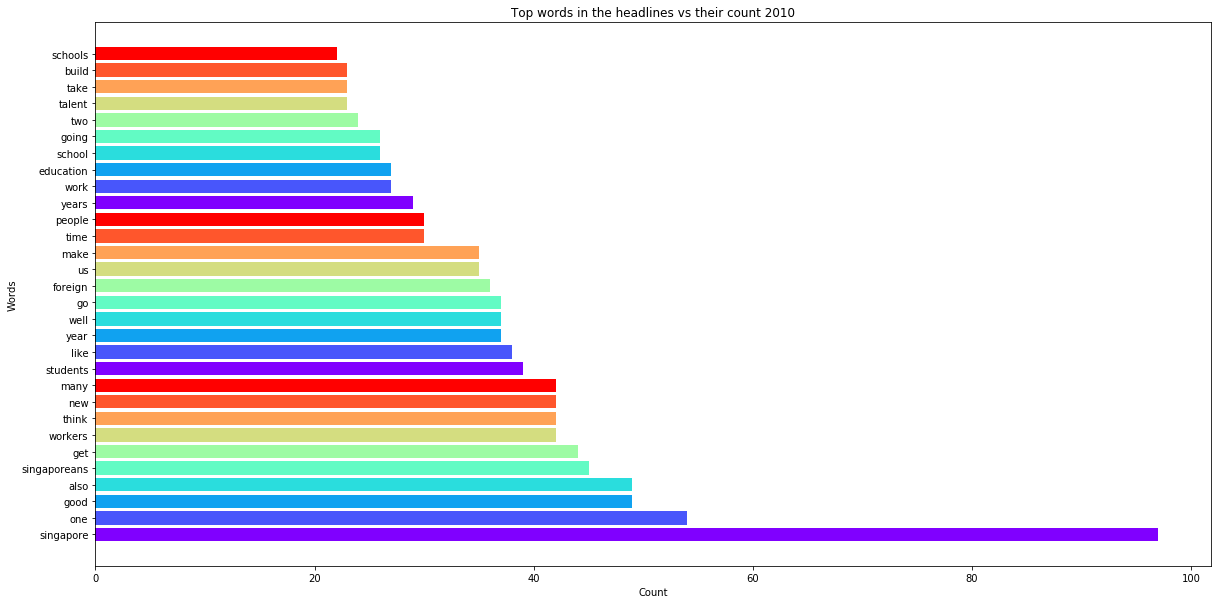

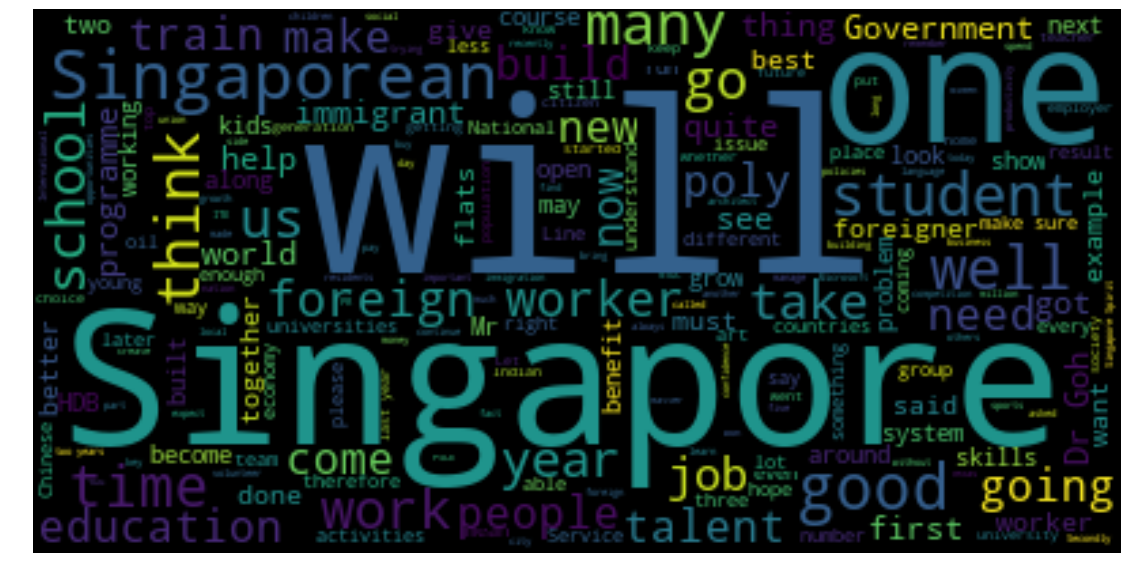

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
special help needs education people good schools support need maybe
Topic 1:
students university universities staff singaporeans foreign singapore make just places
Topic 2:
people project foreigners foreign singaporeans workers need singapore stories pass
Topic 3:
singapore problem right say look depends just term policies greece
Topic 4:
people singapore make think singaporeans government just know year flats


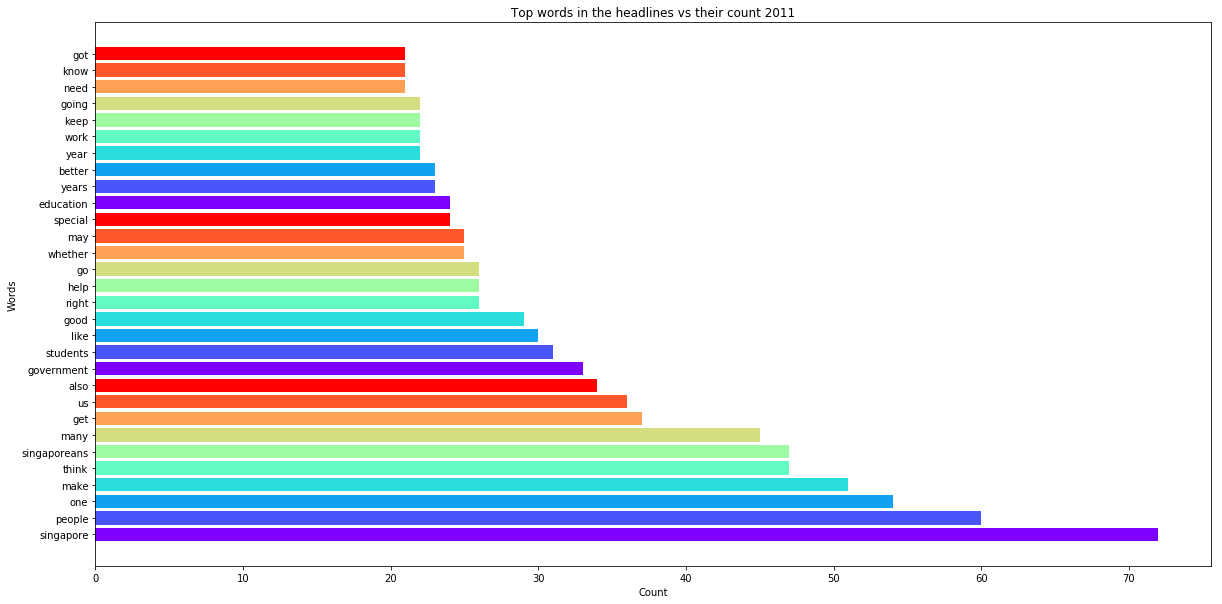

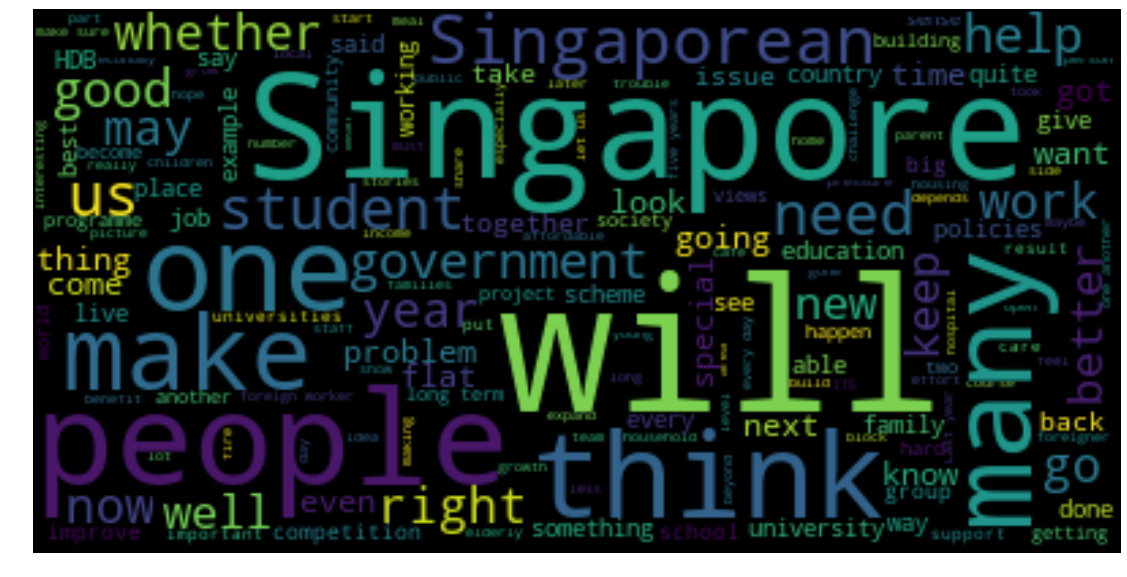

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
children people work time students home just singapore year old
Topic 1:
people time mr toh singapore better use courses graduates new
Topic 2:
think preschool education raise going time students support operators make
Topic 3:
think singapore singaporeans like school world new people just students
Topic 4:
world new singapore years government think memories reserves spending people


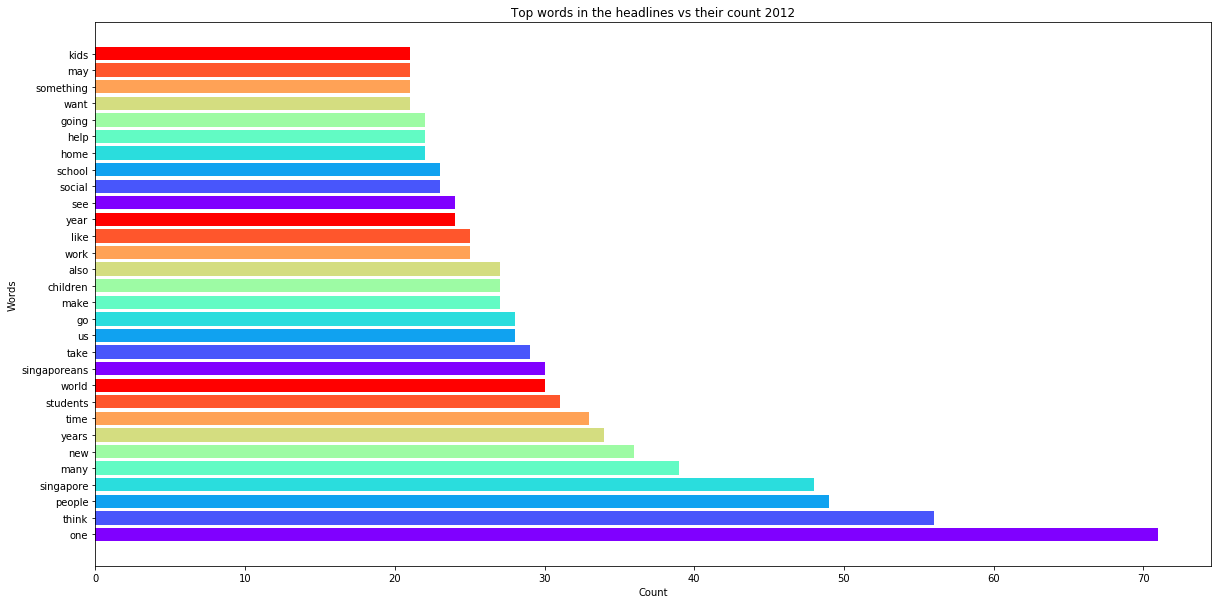

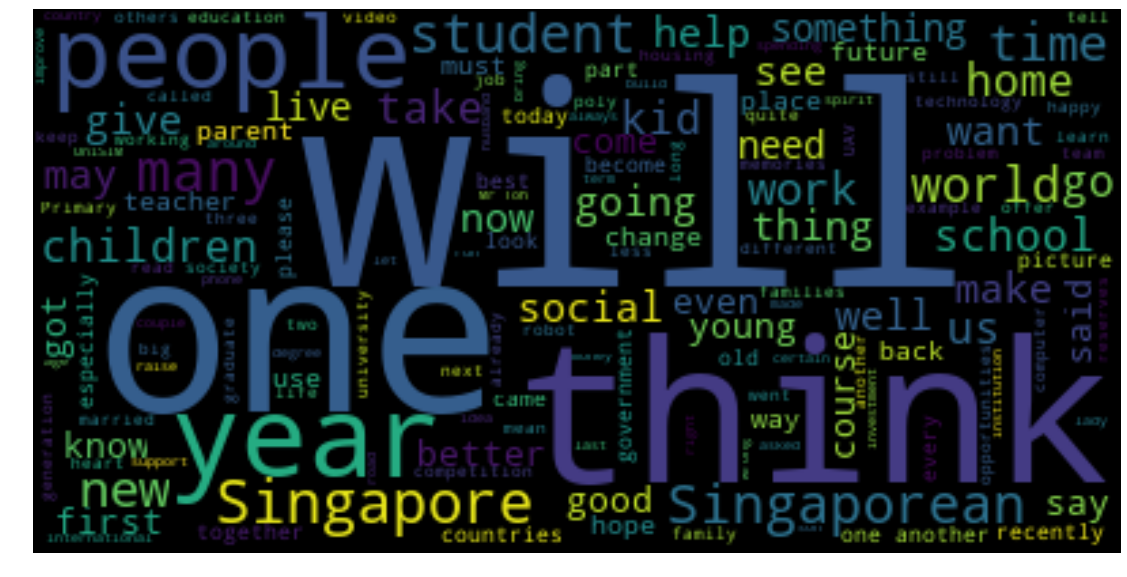

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
people make singaporeans community singapore new time day government healthcare
Topic 1:
000 flat room singapore new flats income changi airport households
Topic 2:
schools school students good make think secondary parents education like
Topic 3:
people think singapore life year medishield problem psle just faith
Topic 4:
think school year want singapore generation better schools time need


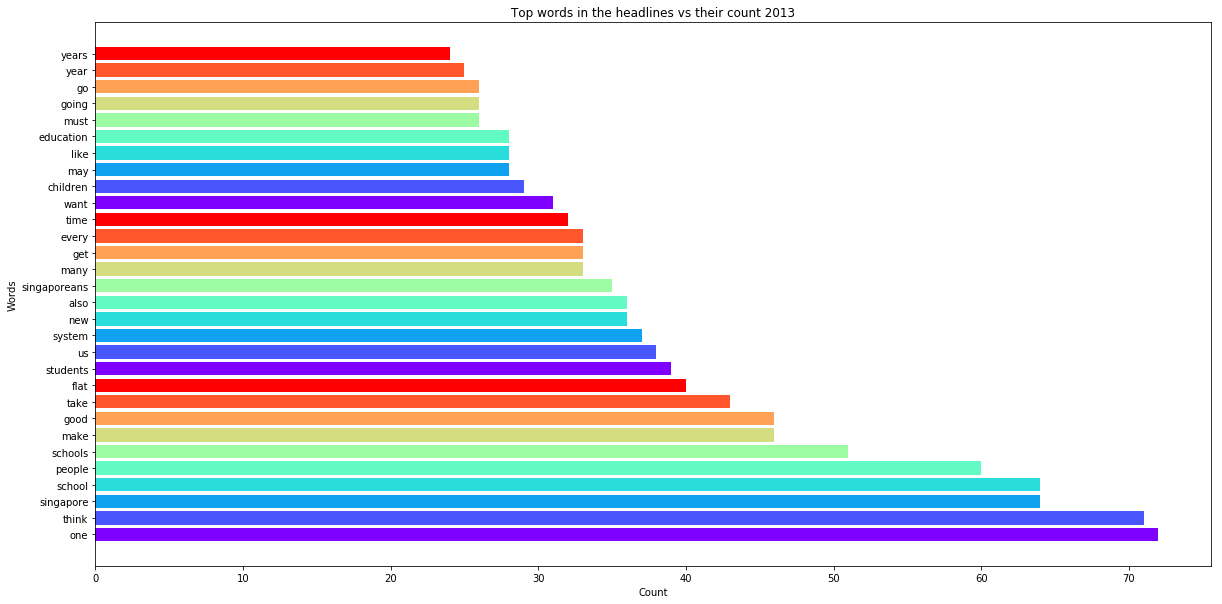

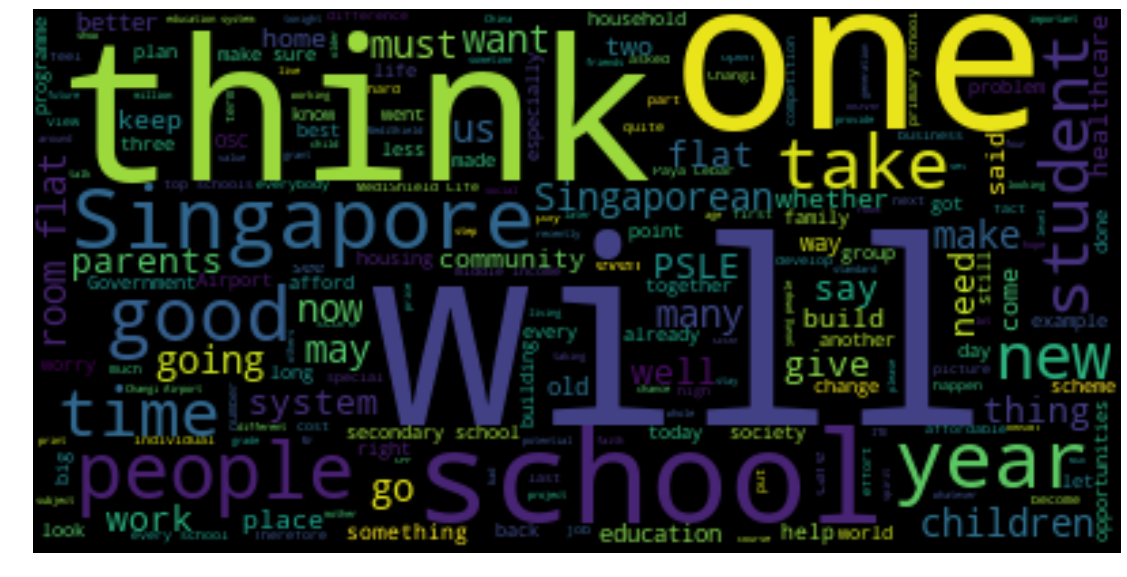

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
pm bakar keppel singapore mr abu want job yes han
Topic 1:
jurong gardens lake garden good just cpf government year help
Topic 2:
cpf house years government said singapore need 000 pioneer mr
Topic 3:
flat month 000 think singapore mr children yusof tan room
Topic 4:
mr year singapore people 000 need rahmat life just help


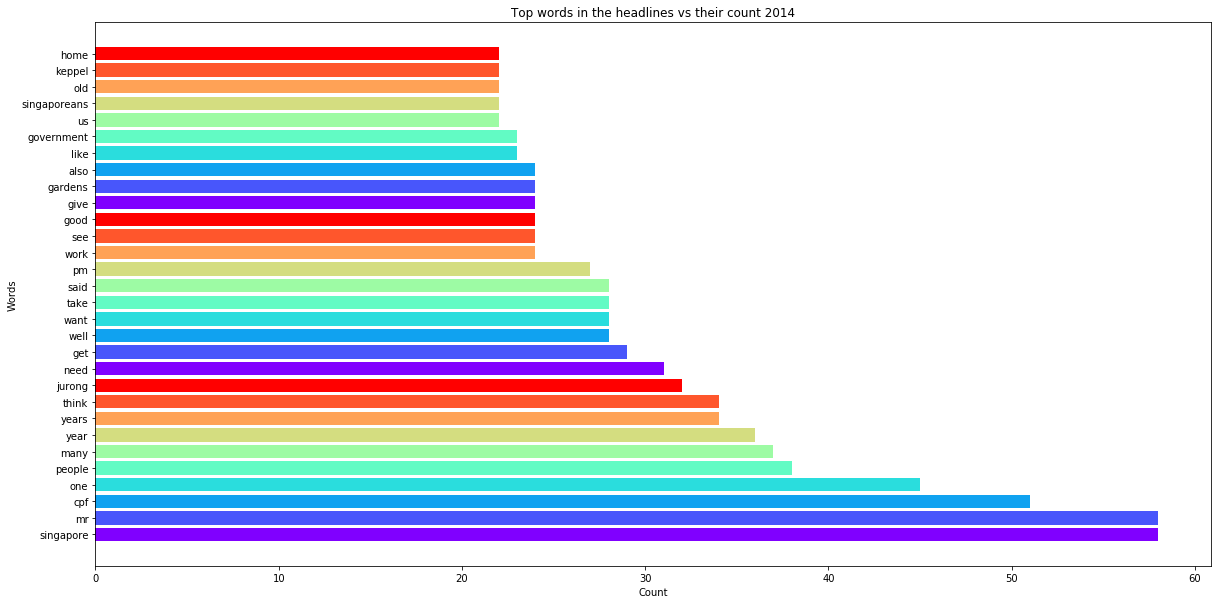

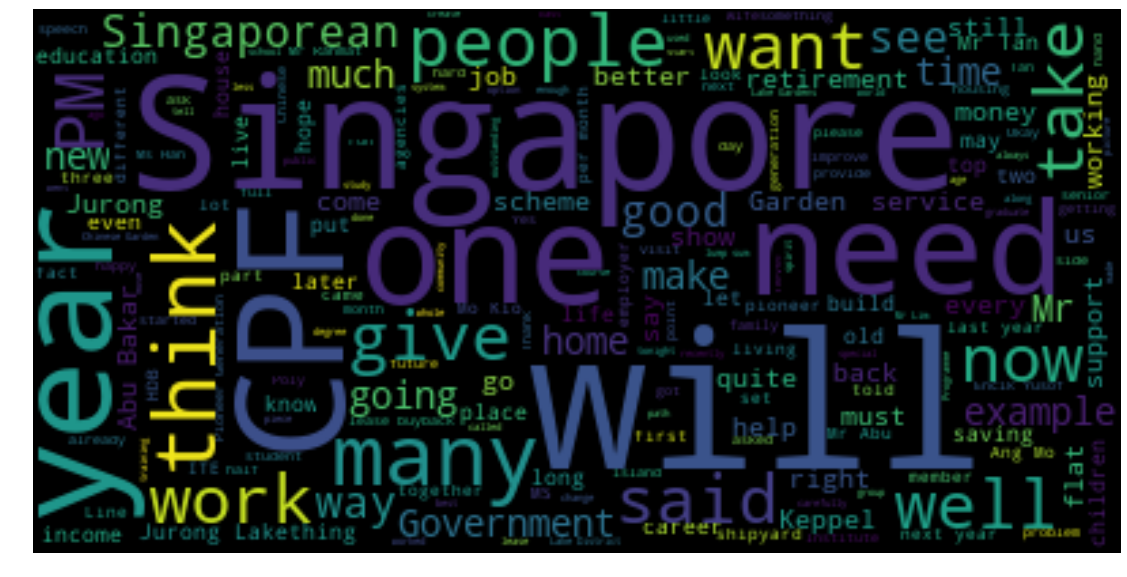

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
help world year flat singapore just national group child day
Topic 1:
lee mr singapore sit singaporeans year years sg50 punggol spirit
Topic 2:
years people good singapore long want 50 problems say work
Topic 3:
people time work shg government students singapore help flat education
Topic 4:
singapore years sg50 flats old hdb did home children parents


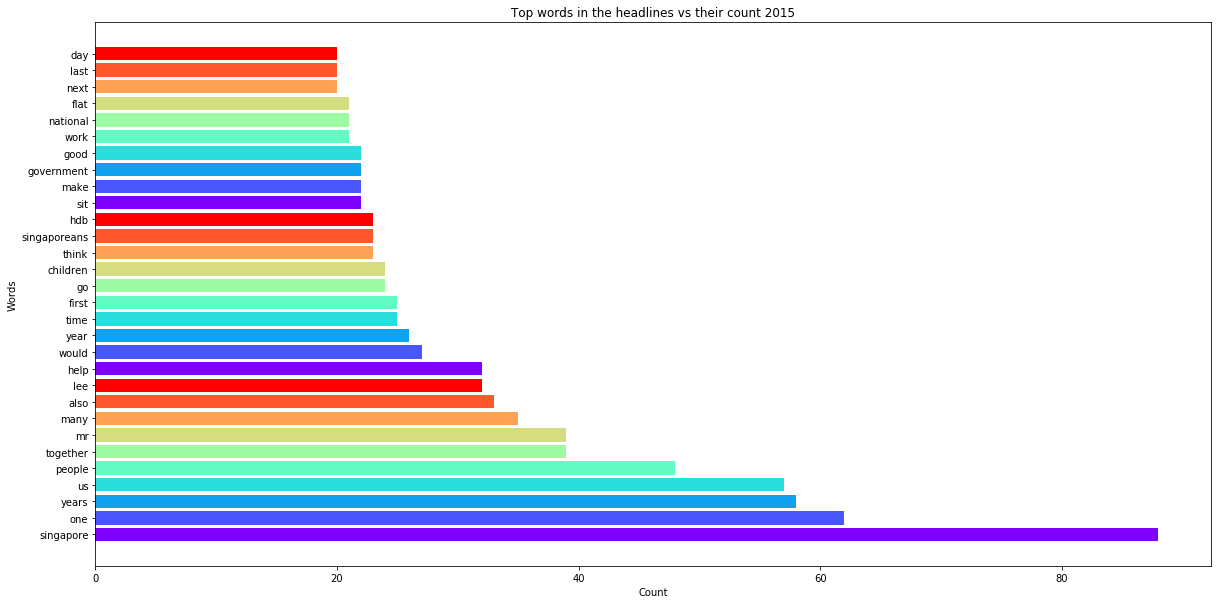

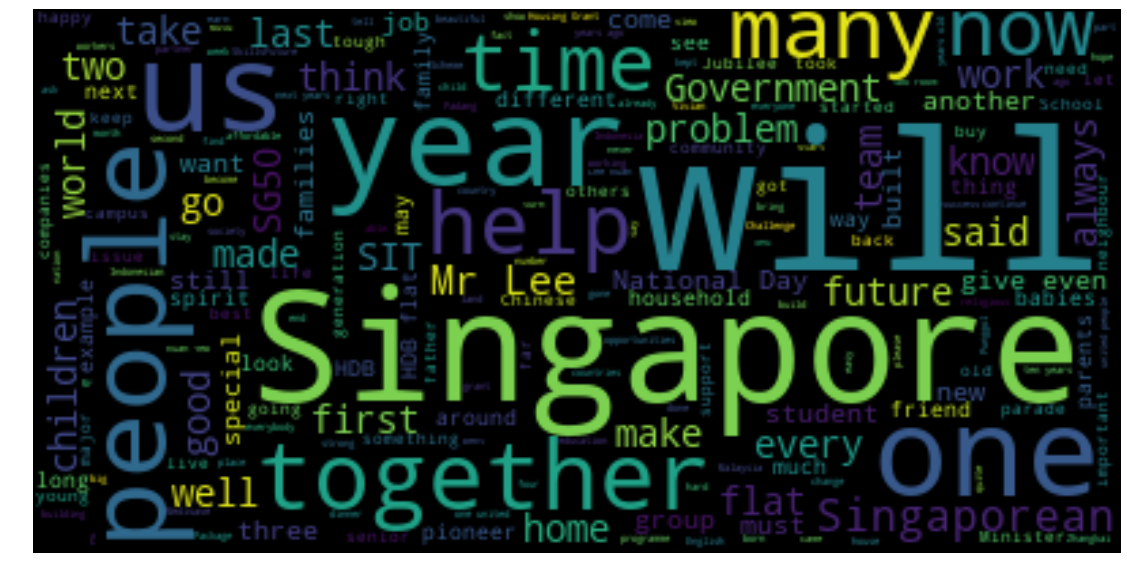

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
china singapore sea people south countries asean president race friends
Topic 1:
president make need drivers people work government sure singapore want
Topic 2:
president singapore time minority minorities billion indonesia international did malaysia
Topic 3:
new people need business singapore block jobs doing companies like
Topic 4:
new singapore world doing need jobs society attack just taken


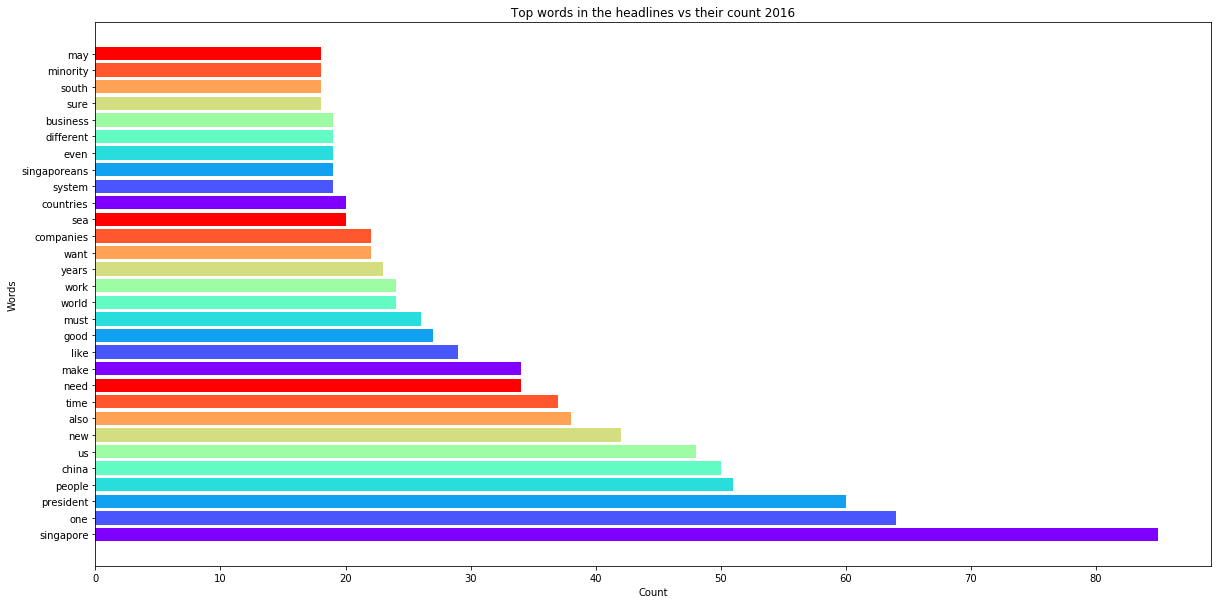

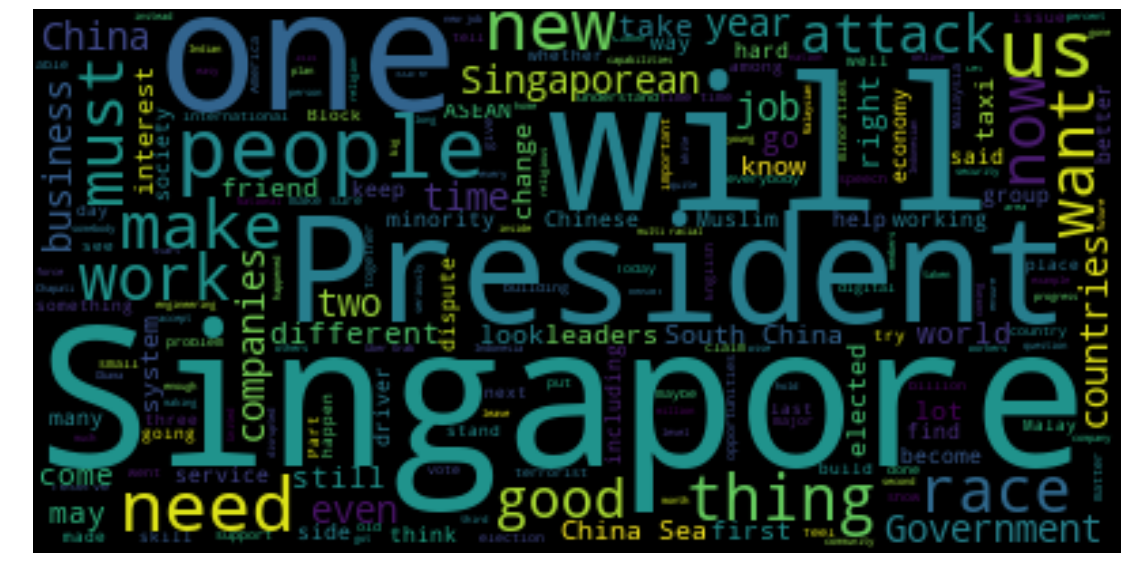

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
preschool good teachers children moe early child years start career
Topic 1:
singapore cash pay need parking make payments cities code qr
Topic 2:
years rice like smart future white live old adam nation
Topic 3:
diabetes year day sugar years singaporeans drinks soft group just
Topic 4:
engineering bank people using lee know mr half mobile sugar


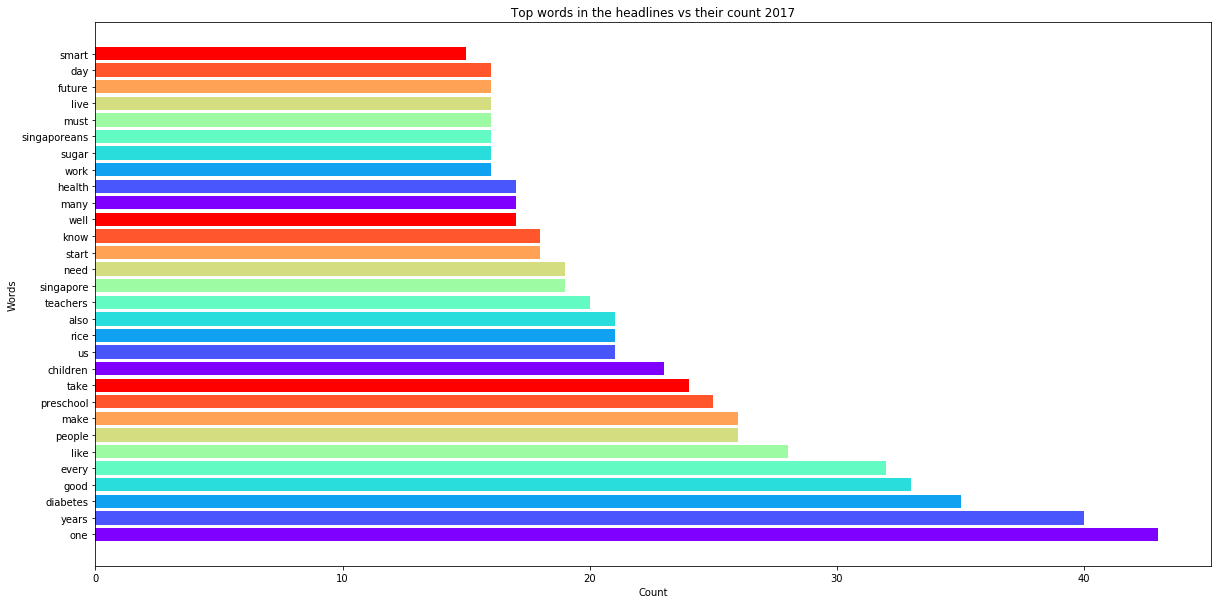

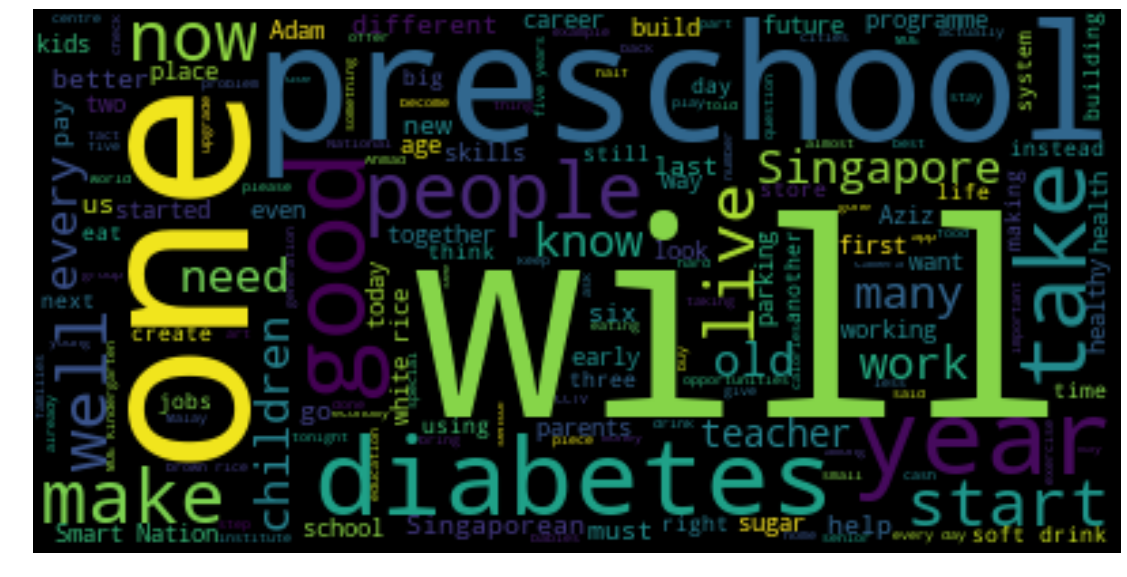

Number of stop words: 179
First ten stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Topic 0:
years flats hip old new flat hdb government leases time
Topic 1:
sers flats residents like hdb good singapore officers estate redevelop
Topic 2:
flat chas generations government life flats singaporeans new future singapore
Topic 3:
generation merdeka singapore healthcare school package kah chun world life
Topic 4:
flat years housing want hdb healthcare lease punggol singaporeans mo


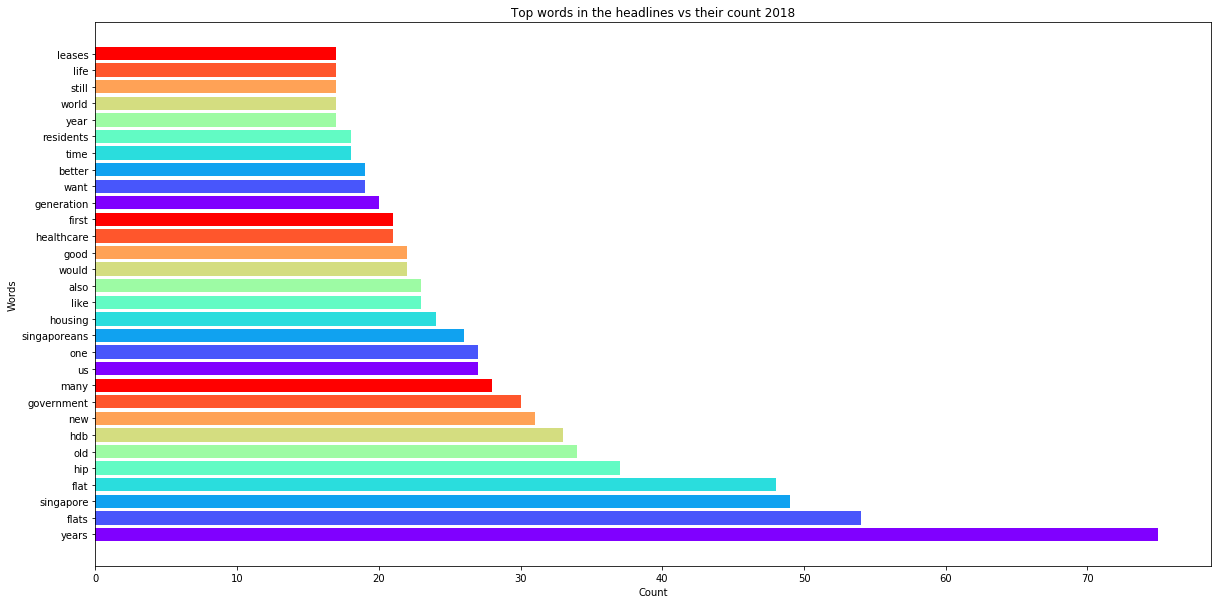

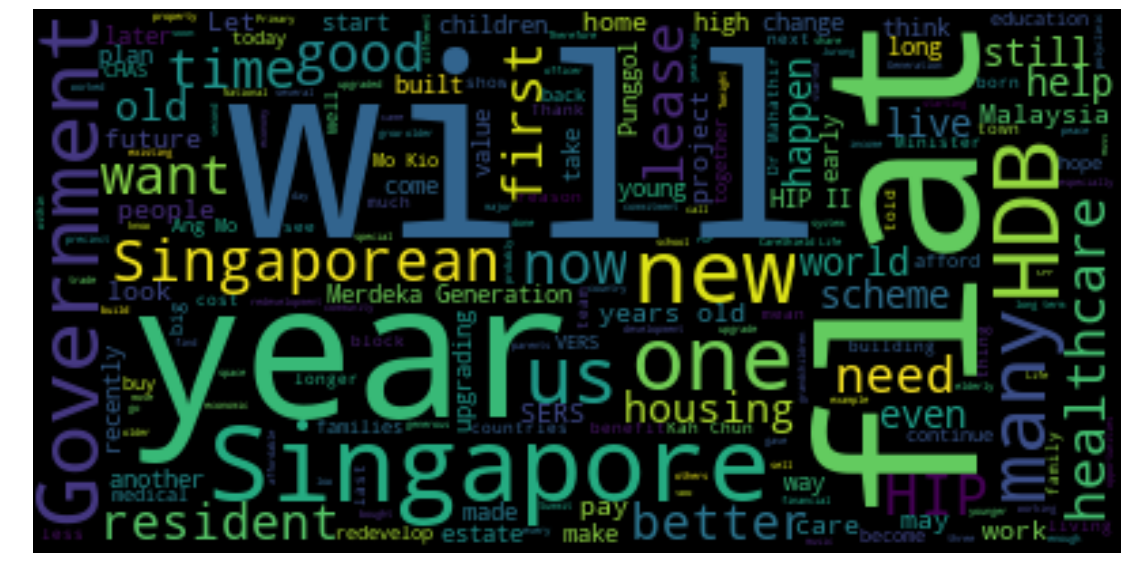

No handles with labels found to put in legend.


[(88, 'singapore'), (62, 'one'), (58, 'years'), (57, 'us'), (48, 'people'), (39, 'together'), (39, 'mr'), (35, 'many'), (33, 'also'), (32, 'lee'), (32, 'help'), (27, 'would'), (26, 'year'), (25, 'time'), (25, 'first'), (24, 'go'), (24, 'children'), (23, 'think'), (23, 'singaporeans'), (23, 'hdb'), (22, 'sit'), (22, 'make'), (22, 'government'), (22, 'good'), (21, 'work'), (21, 'national'), (21, 'flat'), (20, 'next'), (20, 'last'), (20, 'day'), (19, 'team'), (19, 'take'), (19, 'every'), (18, 'made'), (18, 'future'), (17, 'world'), (17, 'well'), (17, 'two'), (17, 'said'), (17, 'old'), (17, 'like'), (17, 'flats'), (17, 'always'), (16, 'still'), (16, 'special'), (16, 'home'), (16, 'could'), (16, 'another'), (15, 'three'), (15, 'must'), (15, 'know'), (15, 'give'), (15, 'get'), (15, 'built'), (14, 'want'), (14, 'students'), (14, 'new'), (14, 'families'), (14, 'even'), (13, 'support'), (13, 'society'), (13, 'housing'), (13, 'come'), (13, 'babies'), (13, 'around'), (13, 'ago'), (12, 'workers'),

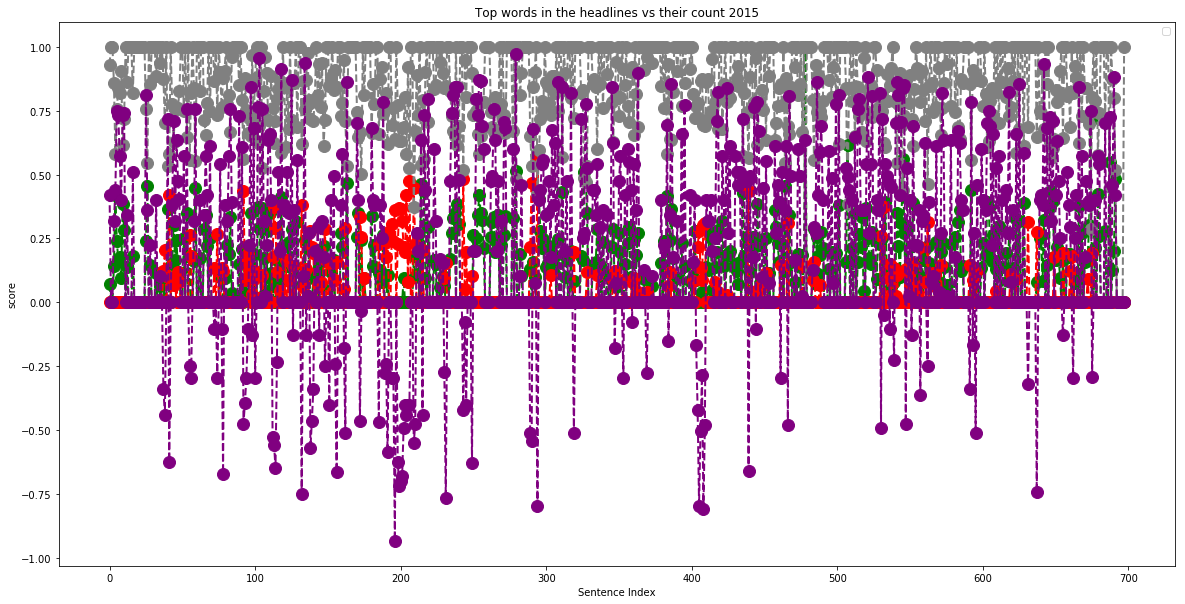

19
19
17
11
13
17
13
15
17
13
14


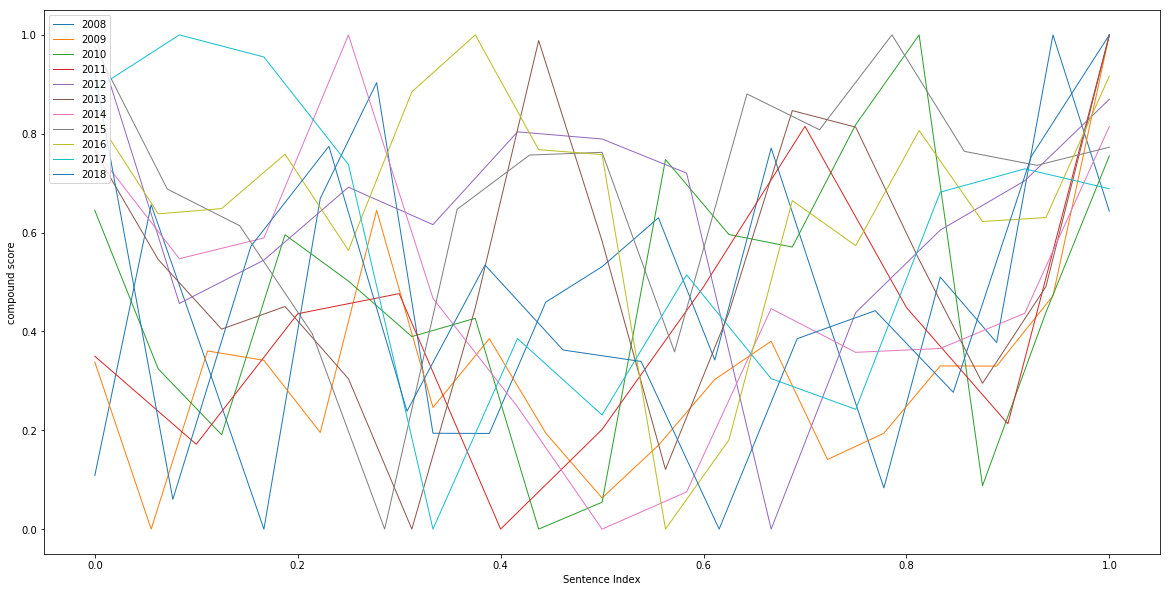

In [0]:
for year in years:  
  # account for different URL structures in the PMO website
  pmo = "https://www.pmo.gov.sg/Newsroom/national-day-rally-"
  pmo_url = "https://www.pmo.gov.sg/Newsroom/prime-minister-lee-hsien-loongs-national-day-rally-"
  pmo_url_2013 = "https://www.pmo.gov.sg/Newsroom/prime-minister-lee-hsien-loongs-national-day-rally-" 
  pmo_lang_2013 = "-english"
  pmo_lang = "-speech-english"
  
  if (year<2013):
    current_year = pmo_url + str(year) + pmo_lang
  
  elif(year==2013):
    current_year = pmo_url_2013 + str(year) + pmo_lang_2013
  
  elif(year>=2014):
    current_year = pmo + str(year)
        
  content = requests.get(current_year)
  soup = BeautifulSoup(content.text, 'html.parser')
  search_result = soup.findAll(name='div', attrs={'class': 'row qna'})
  text_extracted = search_result[1].get_text()  
  speech_list.append(text_extracted)
  words_tokenized = clean_words(text_extracted)
  para_list = split_text_into_paras(text_extracted)  
  
  visualize_graph(words_tokenized, year)
  
  text_tokenized[year] = words_tokenized
  
  results = sentiment_analysis(text_extracted)
  
  pol_score[year] = results
  
  topic_modeller(para_list)
  
  word_cloud_gen(text_extracted)
  
  speeches.append(text_extracted)
  
print(text_tokenized[2015])
print(pol_score[2015])
visualize_sentiment_analysis(pol_score, 2015)
display_overall_score(pol_score, years, 50)

# Topic modelling for *all* of the speeches


In [0]:
# create new dataframe with year and speeches only

speech_df = pd.DataFrame({"year": years, "speech_text": speech_list})

#speech_df

In [0]:
topic_modeller(speech_df["speech_text"])

Topic 0:
income going room flat parents lot flats open
Topic 1:
diabetes preschool rice teachers health sugar moe smart
Topic 2:
president cpf pm jurong going job month companies
Topic 3:
flats flat foreign housing religious lee healthcare team
Topic 4:
social going kids having parents read university housing
